<h1 align="center"><b>Homework Assignment 2 (100 points total)</b></h1>
<h3 align="center"><b>Assigned at the start of Module 3</b></h3>
<h3 align="center"><b>Due at the end of Module 5</b></h3><br>


# Q1: Outlier Detection with Mahalanobis Distance

## Developing multi-variate methods for outlier detection (40 points total)

The **Mahalanobis distance** provides a statistical measure of the distance between a point and a distribution. When applied to multivariate data, **ellipses** can help visualize outliers by showing confidence regions for different standard deviations.

You have been given a dataset (**Iris dataset**) with three species of flowers: **Setosa, Versicolor, and Virginica**. Each species has measurements for:
- **Sepal Length**
- **Sepal Width**
- **Petal Length**
- **Petal Width**

---

## **Tasks**

### **1. Conceptual Understanding (10 points)**
- Explain why **Mahalanobis distance-based ellipses** are useful for outlier detection.
- Compare this method with **standard deviation-based outlier detection** in one-dimensional data.

---

### **2. Implementation (10 points)**
- Use the provided code to **generate ellipses** for all three species using the features **sepal_length** and **petal_width**.
- Modify the class **`sigma_ellipse_plot`** to allow for the selection of **custom standard deviation thresholds** (e.g., `[1.5, 2.5, 3.5]` instead of `[1, 2, 3]`).

---

### **3. Analysis and Interpretation (10 points)**
- Based on your plot, **identify a point that falls outside the 3-standard deviation ellipse**. Is it an outlier? **Justify your answer.**
- What would happen if the **covariance** between the selected features was **higher**? How would the **ellipse change**?

---

### **4. Beyond Visual Identification (10 points)**
- The error ellipses provide a visual representation of outliers, but in many real-world applications, visualization may not be feasible for high-dimensional data. How can this method be used to identify outliers numerically without relying on visualization?


## Example Code

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
import math
from scipy.stats.distributions import chi2
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from sklearn import datasets
#%matplotlib inline

class sigma_ellipse_plot:

    def __init__(self, df=None, target='setosa', target_header='species', feature1='sepal_length', feature2='petal_width', std_devs=[1, 2, 3]):

        self.data = df
        self.target = target
        self.feature1 = feature1
        self.feature2 = feature2
        self.target_header = target_header
        self.std_devs=std_devs
        self.largest_eigenvalue = None
        self.largest_eigenvector = None
        self.smallest_eigenvalue = None
        self.smallest_eigenvector = None
        self.angle = None
        self.mean = None
        self.r_ellipses = None
        self.mu_X = None
        self.mu_Y = None
        self.chisquare_val = None

    def get_data(self):

        self.data = self.data[self.data[self.target_header] == self.target].drop(self.target_header, axis =1)[[self.feature1, self.feature2]]

        return

    def get_eigens(self):

        covariance_matrix = self.data.cov()
        eigenvalues, eigenvectors = eigh(covariance_matrix)

        self.largest_eigenvector = eigenvectors[np.argmax(eigenvalues)]
        self.largest_eigenvalue = np.max(eigenvalues)
        self.smallest_eigenvector = eigenvectors[np.argmin(eigenvalues)]
        self.smallest_eigenvalue = np.min(eigenvalues)

        return

    def get_angle(self):

        self.angle = math.atan2(self.largest_eigenvector[1], self.largest_eigenvector[0])

        return

    def shift_angle(self):

        if self.angle < 0:
            self.angle = self.angle + 2*math.pi

        return

    def get_mean(self):

        self.mean = self.data.mean()

        return

    def get_chisquare_vals(self):

        self.chisquare_val = []
        for i in range(0, len(self.std_devs)):
            percent_covered = stats.norm.cdf(self.std_devs[i]) - stats.norm.cdf(self.std_devs[i] * -1)
            self.chisquare_val.append((chi2.ppf(percent_covered, df=2))**0.5)

        return self.chisquare_val

    def get_ellipses(self):

        chisquare_val = self.get_chisquare_vals()

        self.r_ellipses = []
        for i in range(0, len(self.std_devs)):
            theta_grid = np.linspace(0,2*math.pi, 100)
            phi = self.angle
            self.mu_X = self.mean[0]
            self.mu_Y = self.mean[1]
            a = chisquare_val[i] * math.sqrt(self.largest_eigenvalue)
            b = chisquare_val[i] * math.sqrt(self.smallest_eigenvalue)

            ellipse_x_r = a * np.cos(theta_grid)
            ellipse_y_r = b * np.sin(theta_grid)

            R = [[math.cos(phi), math.sin(phi)], [-math.sin(phi), math.cos(phi)]]

            ellipses = np.array([ellipse_x_r, ellipse_y_r])

            r_ellipse = ellipses.T.dot(R).T

            self.r_ellipses.append(r_ellipse)

        return
    
    def get_labels(self, special_phrase=None):

        labels = []
        for i in range(0, len(self.std_devs)):

            if special_phrase is None:
                label = str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)
            else: 
                label = special_phrase + str(self.std_devs[i]) + " std. dev. from mean"
                labels.append(label)

        return labels

    def pipeline(self):

        self.get_data()
        self.get_eigens()
        self.get_angle()
        self.shift_angle()
        self.get_mean()
        self.get_ellipses()

        return self.data, self.r_ellipses, self.mu_X, self.mu_Y


In [25]:
## Import Dataset ##

iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df.columns = (
    df.columns.str.replace(' ', '_') 
    .str.replace(r'\(cm\)', '', regex=True) 
    .str.lower()
    .str.rstrip('_')) 
df['species'] = iris.target
df['species'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
print(df.head())

## Feature Definition ##

feature1 = 'sepal_width'
feature2 = 'petal_width'

## Species Specific Ellipse Generation ##

setosa_ellipses_obj = sigma_ellipse_plot(df=df, target='setosa', feature1=feature1, feature2=feature2)
setosa_df, setosa_ellipses, setosa_mu_X, setosa_mu_Y = setosa_ellipses_obj.pipeline()
setosa_plot_labels = setosa_ellipses_obj.get_labels()

versicolor_ellipses_obj = sigma_ellipse_plot(df=df, target='versicolor', feature1=feature1, feature2=feature2)
versicolor_df, versicolor_ellipses, versicolor_mu_X, versicolor_mu_Y = versicolor_ellipses_obj.pipeline()
versicolor_plot_labels = versicolor_ellipses_obj.get_labels()

virginica_ellipses_obj = sigma_ellipse_plot(df=df, target='virginica', feature1=feature1, feature2=feature2)
virginica_df, virginica_ellipses, virginica_mu_X, virginica_mu_Y = virginica_ellipses_obj.pipeline()
virginica_plot_labels = virginica_ellipses_obj.get_labels()

   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


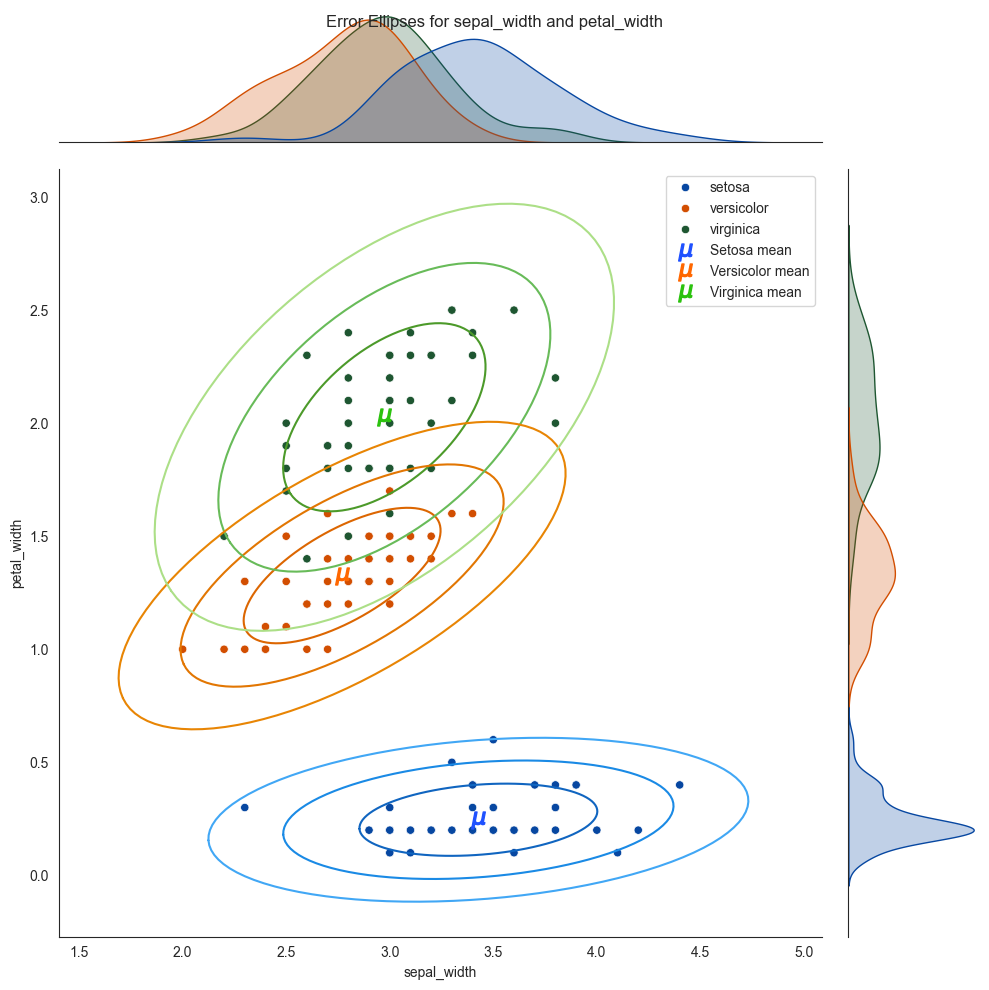

In [26]:
## Visualization of Ellipse Plots ##

sns.set_style("white")

df_subset = df[[feature1, feature2, 'species']]

# palette order - setosa, virginica, versicolor
petal_width_plot = sns.jointplot(data=df_subset, x=feature1, y=feature2, hue="species", palette = ["#0747a1", '#d24e01','#1e5631' ], height = 10)
colors_for_plot_setosa = ['#1065c0', '#1a8ae5', '#41a7f5']
colors_for_plot_virginica = ['#4c9a2a', '#68bb59', '#acdf87']
colors_for_plot_versicolor = ['#dc6601', '#e27602', '#e88504']

# Dynamic title for chart 
plt.suptitle(f"Error Ellipses for {feature1} and {feature2}" )

plt.scatter(setosa_mu_X, setosa_mu_Y, c='#1F51FF', s=150, label = 'Setosa mean', marker='$\mu$')
plt.scatter(versicolor_mu_X, versicolor_mu_Y, c='#FF6700', s=150, label = 'Versicolor mean', marker='$\mu$')
plt.scatter(virginica_mu_X, virginica_mu_Y, c='#2Bc20e', s=150, label = 'Virginica mean', marker='$\mu$')

plt.legend()

# Plots the ellipses for each species, with the appropriate colors 
for i in range(0, len(setosa_ellipses)):
    plt.plot(setosa_ellipses[i][0] + setosa_mu_X, setosa_ellipses[i][1] + setosa_mu_Y, colors_for_plot_setosa[i], label= setosa_plot_labels[i])
    plt.plot(versicolor_ellipses[i][0] + versicolor_mu_X, versicolor_ellipses[i][1] + versicolor_mu_Y, colors_for_plot_versicolor[i], label= versicolor_plot_labels[i])
    plt.plot(virginica_ellipses[i][0] + virginica_mu_X, virginica_ellipses[i][1] + virginica_mu_Y, colors_for_plot_virginica[i], label= virginica_plot_labels[i])

# Save the plot as an image
plt.savefig('MahalanobisOultlierExample.svg')

# Show the plot (optional)
plt.show()

# **Q2: Data Modeling**

## Explore various approaches to formulating a problem statement and selecting the appropriate type of model for the task (30 points total)

In this assignment, you will explore different **modeling approaches** using the **UCI Adult Income Dataset**. This dataset contains various **demographic and income-related attributes**, allowing for diverse modeling techniques.

---

## **Tasks**

### **1. Understanding the Data (5 points)**
- Download the **UCI Adult Income Dataset** from the **UCI Machine Learning Repository**.
- Perform **exploratory data analysis (EDA)** to understand its structure, including:
  - Identifying missing values.
  - Analyzing distributions.
  - Determining feature types.

---

### **2. Problem Formulation & Model Selection (10 points)**
- Choose **two different modeling approaches** from the following categories:
  - **Statistical Algorithms** (e.g., **Expectation-Maximization (EM), Gaussian Mixture Models (GMM), Naive Bayes, Bayesian classifiers**).
  - **Optimization Algorithms** (e.g., **Linear Programming (LP), Integer Programming (IP), Dynamic Programming (DP), Quadratic Programming (QP), heuristic/metaheuristic methods**).
  - **Graph Algorithms** (e.g., **network construction based on occupation/education, shortest path analysis**).
  - **Supervised Learning** (classification or regression).
  - **Unsupervised Learning** (clustering, dimensionality reduction).
- **Formulate a problem statement** for each **chosen model type**, clearly defining:
  - **What you aim to achieve** using each approach.

---

### **3. Implementation (10 points)**
- Implement **both models** using Python and built-in functions from:
  - **Scikit-Learn**
  - **SciPy**
  - **NetworkX**
  - Or other relevant libraries.
- **Describe the methodology** behind each model and explain **why it is appropriate** for the problem you formulated.

---

### **4. Evaluation & Comparison (5 points)**
- **Compare the two approaches**:
  - **What insights does each model provide?**
  - **How do the results differ?**
  - **What are the trade-offs** between the two modeling techniques?


In [5]:
import pandas as pd
import numpy as np

column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income"
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
df = pd.read_csv(url, names=column_names, na_values=" ?", skipinitialspace=True)

df.head()



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# **Q3: Gaussian Mixture Models and Expectation-Maximization**

## **Analyzing runtime and implementing GMMs for a single-variate dataset (30 points total)**
The **Iris dataset** contains measurements of **sepal length, sepal width, petal length, and petal width** for three species of flowers: **Setosa, Versicolor, and Virginica**. In this assignment, you will focus on **one feature only** (e.g., **Petal Length**) and use **Gaussian Mixture Models (GMMs) with the Expectation-Maximization (EM) algorithm** to model the distribution of this feature.

Unlike traditional clustering, GMMs use **probabilistic modeling** to represent data as a **mixture of Gaussians**, making them useful for capturing **uncertainty** and **overlapping distributions**.

---

## **Tasks**

### **1. Understanding Gaussian Mixture Models and the EM Algorithm (5 points)**
- Explain how the **Expectation-Maximization (EM) algorithm** is used to fit a **Gaussian Mixture Model (GMM)**.
- Why is a **mixture of Gaussians** an appropriate way to model a **single feature's distribution**?
- Discuss how GMMs use **probabilities rather than hard assignments** to classify points.

---

### **2. Implementation (15 points)**
- Load the **Iris dataset** and select **one numerical feature** (e.g., **Petal Length**).
- **Manually implement** the **Gaussian Mixture Model (GMM)** using the **Expectation-Maximization (EM) algorithm**:
  - **Do not** use `sklearn.mixture.GaussianMixture` or other built-in GMM solvers.
  - You may use **NumPy and Pandas** for matrix operations and calculations.
  - Initialize **random means, variances, and priors** for **three Gaussians** (since Iris has three species).
  - Implement the **E-step (Expectation)**: Compute the probability that each data point belongs to a given Gaussian.
  - Implement the **M-step (Maximization)**: Update the parameters of each Gaussian distribution.
  - Repeat until **convergence** (based on **log-likelihood stability**).

---

### **3. Runtime Complexity Analysis (5 points)**
- Perform a **line-by-line runtime analysis** of your implementation.
- Determine the **overall time complexity** in **Big O, Big Theta, and Big Omega notation**.
- Discuss the factors affecting runtime, such as:
  - The number of **iterations until convergence**.
  - The number of **data points**.
  - The complexity of **computing probabilities and updating parameters**.

---

### **4. Visualization (5 points)**
- **Plot the raw feature values** (e.g., **petal length**) as a **histogram**.
- **Overlay the fitted Gaussian distributions** on the same plot.
  - Scale the Gaussian curves so they **align properly** with the histogram.
  - Ensure the plot **visually distinguishes between the three Gaussians**.


In [13]:
## Import the dataset ##

import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
